# Editing Known sites - Quick Start

## #Known sites Call Level - Prepare

### Imports

In [ ]:
import pysam
from Bio import SeqIO
import pandas as pd

### Data
##### 1. ADAR_KO bam、ADAR_WT bam
##### 2. REDIportal Known_AG_editing sites
##### 3. ref fasta(hg38)

In [ ]:
# data path
BAM = "./data/1_bam"
REF_fa = "./data/reference/hg38.fa"
KNOWN_SITES = "./data/reference/REDIportal_known_AG_sites_selected_genes.txt"

# bam
ADAR_KO_bam = f"{BAM}/ADAR_KO.bam"
ADAR_WT_bam = f"{BAM}/ADAR_WT.bam"


In [ ]:
# show the REDIportal A-to-I editing sites
KNOWN_SITES_df = pd.read_csv('./data/reference/TABLE1_hg38_v3.txt', sep="\t", header=None,
                             names=["chromosome", "position", "strand"])
print("Known A-to-I editing sites:")
display(KNOWN_SITES_df.head())

### Step 1 -define 'pileup_sites' function

##### 1 - Load input sites / 读取输入位点
        Read tab-delimited file with chromosome and position.

##### 2 - Cluster nearby sites / 聚类邻近位点
        Group sites within a distance threshold per chromosome.

##### 3 - Load reference genome / 加载参考基因组
        Store sequences in uppercase for reference checks.

##### 4 - Pileup and count bases / pileup 并计数碱基
        Count A/T/C/G, calculate coverage and edited reads, compute editing level.

##### 5 - Handle uncovered sites / 处理无覆盖位点
        Sites without reads are recorded with coverage=0 and edit_level=NA.

In [ ]:
def pileup_sites(input_file, bam_file, ref_fasta, map_quality=20, base_quality=30, max_depth=8000, cluster_size=10000):
    """
    Pileup RNA editing sites from BAM (unstranded, single-process).
    Returns: list of tuples (chr, pos, strand, coverage, edited_reads, edit_level)
    """
    # Load sites
    sites_list = []
    with open(input_file) as f:
        for line in f:
            if not line.strip():
                continue
            chrom, pos = line.strip().split("\t")[:2]
            sites_list.append((chrom, int(pos)))

    # Cluster sites
    clusters = cluster_sites(sites_list, cluster_size)

    # Load reference
    ref = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse(ref_fasta, "fasta")}

    results = []

    for chrom, start, end, pos_list in clusters:
        with pysam.AlignmentFile(bam_file, "rb") as bam:
            used_pos = []
            for col in bam.pileup(chrom, start=start, end=end, max_depth=max_depth,
                                  min_mapping_quality=map_quality, min_base_quality=base_quality,
                                  ignore_orphans=False, ignore_overlaps=True, truncate=True):
                pos = col.pos + 1
                if pos not in pos_list:
                    continue

                ref_base = ref[chrom][col.pos]
                strand = "+" if ref_base == "A" else "-" if ref_base == "T" else ref_base

                A=T=C=G=0
                used_pos.append(pos)
                for read in col.pileups:
                    if read.query_position is None or read.alignment.is_secondary:
                        continue
                    if read.is_del and read.is_refskip:
                        continue
                    base = read.alignment.query_sequence[read.query_position].upper()
                    if base == "A": A += 1
                    elif base == "T": T += 1
                    elif base == "C": C += 1
                    elif base == "G": G += 1

                if strand == "+":
                    coverage = A + G
                    edited = G
                elif strand == "-":
                    coverage = T + C
                    edited = C
                else:
                    coverage = edited = 0

                edit_level = round(edited / coverage, 4) if coverage > 0 else "NA"
                results.append((chrom, pos, strand, coverage, edited, edit_level))

            # Handle positions with no coverage
            for pos in set(pos_list) - set(used_pos):
                ref_base = ref[chrom][pos-1]
                strand = "+" if ref_base == "A" else "-" if ref_base == "T" else ref_base
                results.append((chrom, pos, strand, 0, 0, "NA"))

    # Sort results
    results.sort(key=lambda x: (x[0], x[1]))
    return pd.DataFrame(results, columns=["chr", "pos", "strand", "coverage", "mismatch_num", "edi_level"])

def cluster_sites(sites_list, size=10000):
    """
    Cluster nearby sites by chromosome.
    Input: [(chrom, pos), ...]
    Output: [(chrom, cluster_start, cluster_end, [pos1,pos2,...]), ...]
    """
    sites_list = sorted(sites_list, key=lambda x: (x[0], x[1]))
    clusters = []
    current_cluster = []
    current_chro = None
    cluster_start = None

    for chro, pos in sites_list:
        if not current_cluster or (chro == current_chro and pos - cluster_start < size):
            current_cluster.append(pos)
        else:
            clusters.append((current_chro, cluster_start-1, current_cluster[-1], current_cluster))
            current_cluster = [pos]
            cluster_start = pos
            current_chro = chro
        if not cluster_start:
            cluster_start = pos
            current_chro = chro

    if current_cluster:
        clusters.append((current_chro, cluster_start-1, current_cluster[-1], current_cluster))
    return clusters

In [ ]:
# invoke 'pileup_sites' function on both BAM files
ADAR_KO_results = pileup_sites(KNOWN_SITES, ADAR_KO_bam, REF_fa)
ADAR_WT_results = pileup_sites(KNOWN_SITES, ADAR_WT_bam, REF_fa)

# display
display(ADAR_KO_results)
display(ADAR_WT_results)

,chr,pos,strand,coverage,mismatch_num,edi_level
0,chr1,16979025,+,0,0,NA
1,chr1,16979047,+,0,0,NA
2,chr1,16979048,+,0,0,NA
3,chr1,16979049,+,0,0,NA
4,chr1,16979071,+,0,0,NA
...,...,...,...,...,...,...
30764,chrX,154372119,+,2,0,0.0
30765,chrX,154372133,+,2,0,0.0
30766,chrX,154372138,+,2,0,0.0
30767,chrX,154372148,+,2,0,0.0


,chr,pos,strand,coverage,mismatch_num,edi_level
0,chr1,16979025,+,0,0,NA
1,chr1,16979047,+,0,0,NA
2,chr1,16979048,+,0,0,NA
3,chr1,16979049,+,0,0,NA
4,chr1,16979071,+,0,0,NA
...,...,...,...,...,...,...
30764,chrX,154372119,+,2,0,0.0
30765,chrX,154372133,+,2,0,0.0
30766,chrX,154372138,+,2,0,0.0
30767,chrX,154372148,+,2,0,0.0


### Step 2 - filter editing sites by coverage and plot

In [ ]:
# merge results
def merge_results(ADAR_KO_df, ADAR_WT_df, cov = 10):
    ADAR_KO_df = ADAR_KO_df.rename(columns={
        "coverage": "KO_coverage",
        "mismatch_num": "KO_mismatch_num",
        "edi_level": "KO_edi_level"
    })
    ADAR_WT_df = ADAR_WT_df.rename(columns={
        "coverage": "WT_coverage",
        "mismatch_num": "WT_mismatch_num",
        "edi_level": "WT_edi_level"
    })
    merged_df = pd.merge(ADAR_KO_df, ADAR_WT_df, on=["chr", "pos", "strand"] , how="inner")

    filtered_df = merged_df[(merged_df["KO_coverage"] >= cov) & (merged_df["WT_coverage"] >= cov)]

    return filtered_df

def plot_group_scatter(df, cov):

    # KO vs WT
    df_dropNA = df.dropna(subset=["KO_edi_level", "WT_edi_level"])

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.scatter(df_dropNA["WT_edi_level"], df_dropNA["KO_edi_level"], alpha=0.5)
    plt.xlabel("ADAR_WT")
    plt.ylabel("ADAR_KO")
    plt.title(f"Editing Level Scatter Plot (Coverage >= {cov})")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.show()


,chr,pos,strand,KO_coverage,KO_mismatch_num,KO_edi_level,WT_coverage,WT_mismatch_num,WT_edi_level
620,chr1,144421933,-,32,0,0.0,59,0,0.0
621,chr1,144421934,-,34,0,0.0,59,0,0.0
622,chr1,144421935,-,30,0,0.0,61,0,0.0
623,chr1,144421940,-,32,0,0.0,57,0,0.0
624,chr1,144421972,-,32,0,0.0,57,0,0.0
...,...,...,...,...,...,...,...,...,...
30758,chrX,154370929,-,1027,0,0.0,899,0,0.0
30759,chrX,154370932,-,1152,0,0.0,1023,0,0.0
30760,chrX,154370943,-,1223,0,0.0,1107,0,0.0
30761,chrX,154370965,-,1337,0,0.0,1129,0,0.0


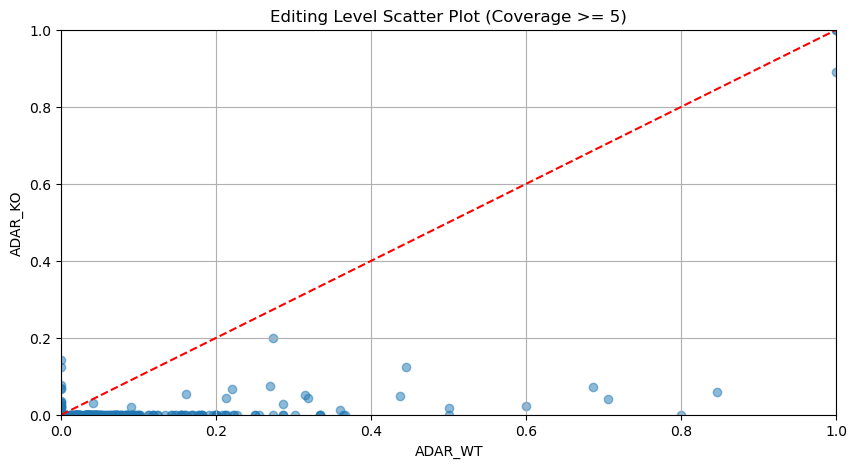

In [ ]:
# merge and plot for coverage >= 5
merged_cov5 = merge_results(ADAR_KO_results, ADAR_WT_results, cov=5)
display(merged_cov5)
plot_group_scatter(merged_cov5, cov=5)

,chr,pos,strand,KO_coverage,KO_mismatch_num,KO_edi_level,WT_coverage,WT_mismatch_num,WT_edi_level
620,chr1,144421933,-,32,0,0.0,59,0,0.0
621,chr1,144421934,-,34,0,0.0,59,0,0.0
622,chr1,144421935,-,30,0,0.0,61,0,0.0
623,chr1,144421940,-,32,0,0.0,57,0,0.0
624,chr1,144421972,-,32,0,0.0,57,0,0.0
...,...,...,...,...,...,...,...,...,...
30758,chrX,154370929,-,1027,0,0.0,899,0,0.0
30759,chrX,154370932,-,1152,0,0.0,1023,0,0.0
30760,chrX,154370943,-,1223,0,0.0,1107,0,0.0
30761,chrX,154370965,-,1337,0,0.0,1129,0,0.0


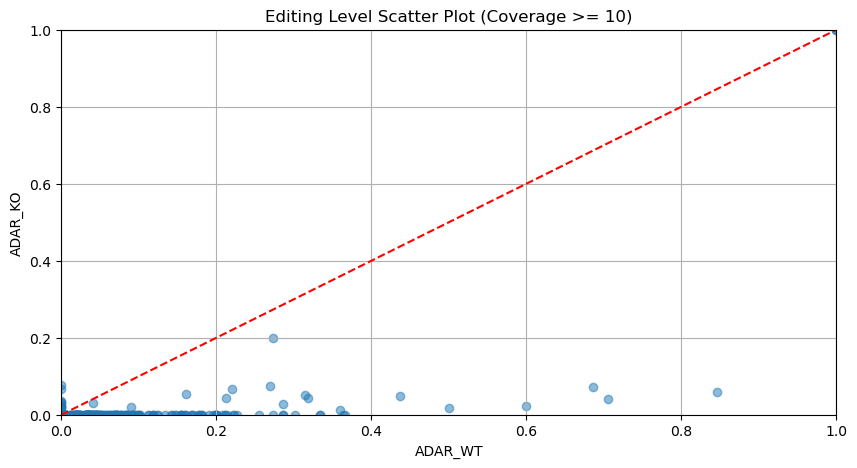

In [ ]:
# merge and plot for coverage >= 10
merged_cov10 = merge_results(ADAR_KO_results, ADAR_WT_results, cov=10)
display(merged_cov10)
plot_group_scatter(merged_cov10, cov=10)

# Thank you very much for your attention, and we’re happy to answer any questions.